<span style="font-family:Papyrus; font-size:3em;">Analysis of Fitting Surfaces</span>

# Preliminaries

In [13]:
from src.surface_analyzer import SurfaceAnalyzer

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import tellurium as te
import pandas as pd
import seaborn as sn
import sympy
import os

In [2]:
NRMSE = "nrmse"  # Normalized root of the mean square error (residuals)

In [3]:
MODEL_DIR = "/home/ubuntu/FittingSurface/models/"

In [4]:
path = os.path.join(MODEL_DIR, "Jana_WolfGlycolysis.antimony")
with open(path, "r") as fd:
    GMODEL = fd.readlines()
GMODEL = "\n".join(GMODEL)

In [5]:
print(GMODEL)

// Created by libAntimony v2.12.0.3

model *Jana_WolfGlycolysis()



  // Compartments and Species:

  compartment compartment_;

  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;

  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;

  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;

  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;

  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;

  species $Sink in compartment_;



  // Reactions:

  J0: $External_glucose => Glucose; J0_inputFlux;

  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));

  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;

  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol;

# One Species (First Order)

## Numerical Studies

Consider the pathway $X0 \xrightarrow{k_1} x \xrightarrow{k_2} X_1$, where $X_0$ and $X1$ have fixed concentrations and reactions kinetics
are mass action with kinetic constants $k_i$.
Then, $\frac{dx}{dt} = k_1 X_0 - k_2 x$.
We want to explore the fitting surface for $k_1, K_2$.

In [6]:
MODEL = """

J1: $X0 -> x; k1*X0
J2: x -> $X1; k2*x

X0 = 1
x = 0
k1 = 1
k2 = 1
"""

In [7]:
PARAMETER_DCT = {"k1": 1, "k2": 2}

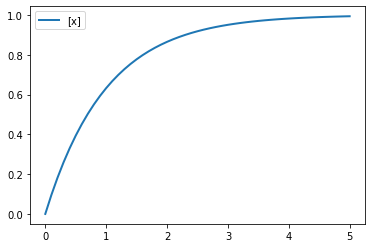

In [8]:
rr = te.loada(MODEL)
trueData = rr.simulate()
rr.plot(trueData)

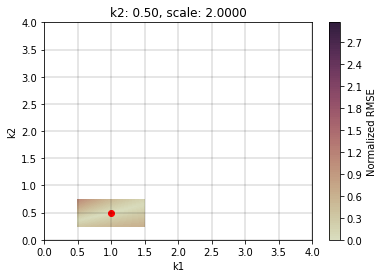

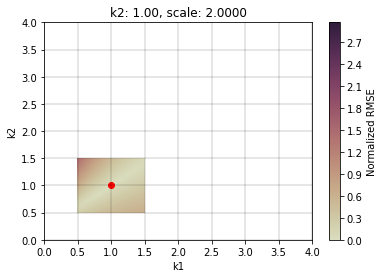

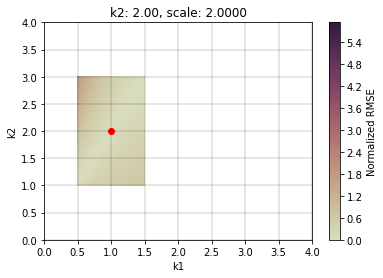

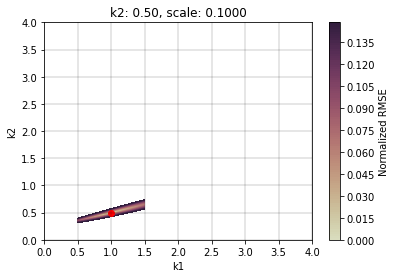

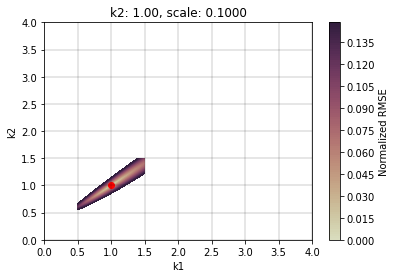

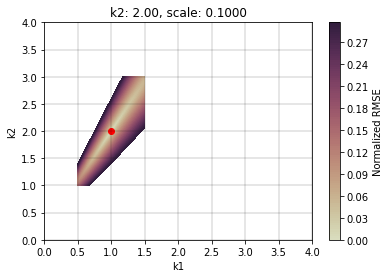

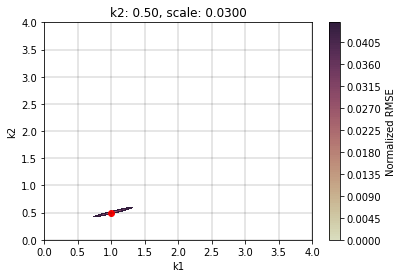

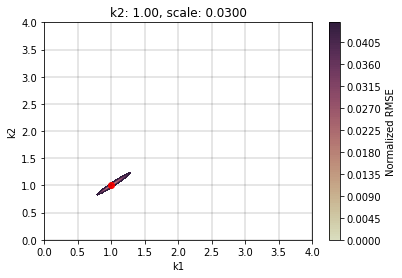

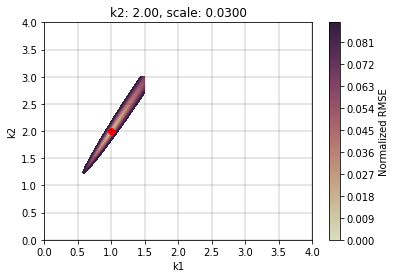

In [9]:
analyzer = SurfaceAnalyzer(MODEL, PARAMETER_DCT)
scales = [2, 0.1, 0.03]
k2s = [0.5, 1.0, 2.0]
for scale in scales:
    for k2 in k2s:
        parameterDct = dict(PARAMETER_DCT)
        parameterDct["k2"] = k2
        analyzer = SurfaceAnalyzer(MODEL, parameterDct)
        analyzer.runExperiments(0.5, 50)
        title = "k2: %2.2f, scale: %2.4f" % (k2, scale)
        analyzer.plotSurface(scale=scale, title=title, xlim=[0, 4], ylim=[0, 4])

**observations**
1. Convex surface
1. Lower values on line with slope $k_1 / k_2$.
1. Steeper slope for minima for $k_2$ compared with $k_1$.

## Analysis

**Result**: Parameter fitting for a one species system is a convex optimization.
Given observational data $y(t)$ for a one species system and $t_{ss}$ such that
$y(t) = x_{ss}$ for $t \geq t_{ss}$.
Let $x(t; k_1, k_2)$ be the system with parameters $k_1, k_2$ and
$k_1^{\star}, k_2^{\star}$ such that $y(t) = x(t; k_1^{\star}, k_2^{\star})$.
We claim that $k_1^{\star}, k_2^{\star}$ are the solution to the following convex optimization:
minimize $\sum_t \left( y(t) - x(t; k_1, k_2) \right) ^2$ such that $\frac{k_1}{k_2} = x_{ss}$.

**Problem setup**
1. The one species system with a constant input $X_0$ and initial condition $x(0)=0$ has the solution.
$x(t) = X_0 \frac{k_1}{k_2}(1 - e^{-k_2 t})$. **[Generalize to non-zero initial conditions]**

1. The residuals are $r(t) =  y(t) - x(t; k_1, k_2) = x(t; k_1^{\star}, k_1^{\star}) - x(t; k_1, k_2)$

1. The sum of squares of the residuals is $R_{SSQ} = \int_0^{\infty} r(t)^2 dt$.


**Analysis for $\frac{k_1}{k_2} = \frac{k^{\star}_1}{k^{\star}_2}$**
1. $r(t) =  A( -e^{-k_2 t} + e^{-k^{\star}_2 t})$, where $A = X_0 \frac{k_1^{\star}}{k_2^{\star}}$.

1. $R_{SSQ} = A^2 \int_0^{\infty} \left( e^{-2k_2 t} -2 e^{-(k_2 + k^{\star}_2)t} + e^{-2k^{\star}_2t} \right)$

1. And so, $R_{SSQ} = A^2 \left( - \frac{1}{2k_2} e^{-2k_2 t} +  \frac{2}{k_2 + k^{\star}_2} e^{-(k_2 + k^{\star}_2)t} - \frac{1}{2k^{\star}_2} e^{-2k^{\star}_2t} \right) \biggr\vert_0^{\infty}$

1. $R_{SSQ} = A^2 \left( \frac{1}{2k_2} -  \frac{2}{k_2 + k^{\star}_2} + \frac{1} {2 k^{\star}_2}  \right)$


In the sequel, we simplify notation by using
$g(u; u^{\star}) = \frac{1}{2 u^{\star}} -  \frac{2}{u + u^{\star}} + \frac{1} {2 u}$, for $u, u^{\star} > 0$.

**Claim:** Given $g(u; u^{\star})$ as defined above:
1. $g(u; u^{\star})$ is positive semidefinite.
1. $g(u; u^{\star}) = 0$ iff $u = u^{\star}$
1. $u^{\star}$ is the solution to a convex optimization.

**Proof:**
The first two claims are established by the following:
$
g(u; u^{\prime})  \geq  0 \equiv u(u + u^{\star}) - 4 u u^{\star} + u^{\star} (u + u^{\star}) \geq 0
\equiv (u - u^{\star}) ^ 2 \geq 0$.
The third claim follow from the fact that minimizing $g(u; u^{\prime})$ is equivalent to solving a convex optimization.

**Claim**: $R_{SSQ}$ is convex in $k^{\star}_2$. **[This may be unnecessary.]**

1. Claim that $\frac{\partial T_{SE}}{\partial k^{\star}} \geq 0$.

1. Note that $\frac{\partial^2 R_{SSQ}}{\partial^2 k^{\star}_2} 
= A^2 \left( \frac{1}{k^3_2} -  \frac{4 }{(k_2 + k^{\star}_2)^3} + \frac{1} {( k^{\star}_2)^3}  \right)$

1. Suffices to show that $ \left( \frac{1}{k^3_2} -  \frac{4 }{(k_2 + k^{\star}_2)^3} + \frac{1} {( k^{\star}_2)^3}  \right) \geq 0$

1. Equivalent to  $(k^{\star}_2)^3  (k^{\star}_2 + k_2)^3 -  4 k^3_2 (k^{\star}_2)^3  + k^3_2 (k^{\star}_2 + k_2)^3 \ge0$.
Let $x = k_2$ and $y = x^{\star}_2$. Then, we have
$x^3 (x + y)^3 -4 x^3 y^3 + y^3 (x + y)^3 \geq 0$, where $x, y > 0$.

$
\begin{align}
T & = & x^3 (x^3 + 3x^2y + 3xy^2 + y^3) - 4 x^3 y^3 + y^3 (x^3 + 3x^2y + 3xy^2 + y^3)  \\
& = & x^3 (x^3 + 3x^2y + 3xy^2) - 2 x^3 y^3 + y^3 ( 3x^2y + 3xy^2 + y^3)   \\
 & = & \left( x^3 - y^3 \right) ^2 + 6x^2y + 6 x y^2 \\
 & \ge 0
\end{align}
$

# Two Species (Second Order)

## Numerial Studies

## Analysis

Second order system: $y^{\prime \prime} + a y^{\prime} + b y = u(t)$

**Solution**

LaPlace Transform: $Y(s) = \frac{U(s)}{s^2 + a s + b}$

**Notes**
1. A key element in minimizing residuals over a longer time course is getting the correct steady state value. Need to constrain search for system parameters based on steady state.

# Linear System

## Convergence for Known A Matrix

Consider a network that is an LTI system. For example, this holds for the following class of reaction networks:
1. Mass action kinetics for at most one reactant.
1. A constant is used in combination with exactly one chemical species.

Let ${\bf A}^{\star}$ be the true matrix for the LTI system, and let ${\bf A} ({\bf k})$ be an estimate of the matrix in terms of the parameters
${\bf k} = (k_1, \cdots, k_N)$.
Our objective function to minimize is $g({\bf k}) = | {\bf A}^{\star} - {\bf A} ({\bf k}) |^2$.
It suffices to show that $\frac {\partial^2g (k_n)}{\partial ^2 k_n} \geq 0$ for each $k_n$.

$
g({k_n})  = | {\bf A}^{\star} - {\bf A} ({k_n}) |^2
$

And so
$\frac{\partial g(k_n)}{\partial k_n} =
2 | {\bf A}^{\star} - {\bf A} ({k_n}) |
\frac{\partial |A^{\star} - A (k_n)|}{\partial k_n}.
$

Finally,
$\frac{\partial^2 g(k_n)}{\partial^2 k_n} =
2
\left( \frac{\partial |A^{\star} - A (k_n)|}{\partial k_n} \right) ^2 
- 2 | {\bf A}^{\star} - {\bf A} ({k_n}) | \frac{\partial^2 |A^{\star} - A (k_n)|}{\partial^2 k_n}.
$

We claim that
$
\frac{\partial^2 |A (k_n)|}{\partial^2 k_n} = 0.
$
This follows from the fact that $k_n$ occurs in only one column since it is associated with only one state variable.
As such, $k_n$ occurs in a product term of the determinant with a power of either 0 or 1.
The second derivative of such terms is 0; and the first derivative of terms without $k_n$ is 0.

**Issues**
1. What does this mean since $A^{\star}$ is unknown?

1. Let ${\bf x}^{\star}$ be the solution to $\dot{{\bf x}}^{\star} = {\bf A}^{\star} {\bf x}^{\star}$.
We have ${\bf x}^{\star}$.
So, we should consider
$h(k_n) = | {\bf x} (0) e^{ {\bf A}^{\star} t } - {\bf x}(0) e^{ {\bf A (k_n)} t } | \approx  
| {\bf x}^{\star} (t)  - {\bf A} (k_n) {\bf x} (0) t |.$
Can make an argument for the $L1$ norm and that the differences are minimized if the matrices converge.

## Convergence of Residuals

Let $A({\bf k})$ be the parameterization of the a linear system with true parameters ${\bf k}^{\star}$.
Define ${\bf x}^{\star}$ as the true solution, and ${\bf r}(t, {\bf k}) =  {\bf x}^{\star} - e^{A({\bf k}) t} x(0)$.
Let
$g({\bf k}) = \int {\bf r}^T (t, {\bf k}) {\bf r} (t, {\bf k})dt$.
Show that $g({\bf k})$ is convex.

1. It suffices to show that $g$ is convex in each $k_n$ for each $t$.
1. $e^{A({\bf k} t} x(0) = \left( \sum_{n=0}^{\infty} \frac{ \left( A({\bf k}) \right)^n t^n}{n!} \right) {\bf x}(0)$.

1. ${\bf r}(t) = \left( \sum_{n=0}^{\infty} \frac{ \left( {\bf A}^{\star} \right)^n - \left( {\bf  A}({\bf k}) \right)^n t^n} {n!} 
\right) {\bf x}(0)$.

1. Let $a_{ij}$ be the $i,j$ element of $\left( {\bf A} (k) \right) ^n$. Note that $a_{ij} = c_m k^m + \cdots + c_0 = P_{ij}^m(k)$,
where $m \leq 2^{n-1}$.
Define $p({\bf A} (k)) = \{ P_{ij}^m \}$.

1. Let $P^m(k)$ be an $m$-th order polynomial in $k$.
   1. $\frac{\partial P^m(k)}{\partial k} = P^{m-1}(k)$.
   1. $sign(c_n^m) = sign(c_{n-1}^{m-1})$ for $n > 0$; otherwise, $sign(c_n) = 0$.
   1. The order of the polynomial of $k$ in ${\bf A}(k)$ is the same as that for
   ${\bf A}(k) {\bf x}$, for a vector ${\bf x}$ that does not contain $k$.
   1. The order of the polynomial of $k$ in ${\bf A}(k)$ is the same as that for
   ${\bf A}^{\star} - {\bf A}(k)$, for a matrix ${\bf A}^{\star}$ that does not contain $k$.
   1. The order of the polynomial of $k$ in ${\bf A}_1(k) + {\bf A}_2(k)$ is
   the max of the order of the polynomials for ${\bf A}_1(k), {\bf A}_2(k)$.
   
1. 
\begin{align*}
\frac{\partial^2 {\bf r}^T (t, k) {\bf r} (t, k)}{\partial^2 k} 
& = &
   \frac {\partial^2 {\bf r}^T (t, k)} {\partial^2 k} {\bf r} (t, k) +
   2 \frac {\partial {\bf r}^T (t, k)} {\partial k}  \frac {\partial {\bf r} (t, k)} {\partial k} +
   {\bf r}^T (t, k)  \frac {\partial^2 {\bf r} (t, k)} {\partial^2 k} \\
\end{align*}

1. A first order Taylor series approximation of $k$ is convex because:
   1. ${\bf A (k)} = \{P^1_{ij} \}$
   1. The second derivatives of ${\bf r}(t, k) \}$ are 0 and the first derviative is squared, and so is positive.
   
1. If ${\bf A}$ is a decompled system, then ${\bf A}$ a diagnonal matrix. This could allow for some reduction in dimensionality for parameter estimation.
We still may have high order polynomials in $k$ for $a_{ii}$.

1. The key consideration is the sign of terms in the polynomials.
    1. If they are always positive, then we get convexity since
terms without $k$ disappear because of the derivative.
    1. If terms of the same sign are multiplied, then the result is positive.
    1. Terms on the diagnonal tend to be negative since they are degradation rates for a species.
    
1. For $A$, and $N \times N$ matrix with $k$ only in $a_{ij}$, find $m$ such that $A^{m+1}$ has the same cells with $k$ as $A^m$.

1. Suppose $X_i$ is the reactant in a reaction that produces $X_j$ with mass action kinetics and constant $k$.
Then, $k$ has a positive sign in $a_{ji}$ and a negative sign in $a_{ij}$.
Let $B = A^2$.
Then, 
   * $b_{ii} = b_{jj}$ has the term $-k^2$
   * $b_{ik}$ has the term $-k$
   * $b_{kj}$ has the term $k$

1. Let $\{ a^m_{ij}\} = {\bf A}^m (k)$.
The sign of $a^m_{ij}$ depends on the sign of non-$k$ terms in the matrix.
In particular, the negative diagnonal.

1. The two main considerations in this analysis is the order of $P^m_{ij}(k)$ and the sign of the terms in the polynomial.

1. Another strategy is to construct an approximation to ${\bf x} (k)$ based on parts of different matrices in the
exact solution such that all terms with $k$ are positive.
This will yield a convex function.
The construction of this approximation depends on ${\bf A}$, where $-k$ occurs in $\left( {\bf A} (k) \right)^m$.
This seems feasible to construct if:

   * $ \{ a_{ij} \} $ is the some of terms of the same sign and
   * $k$ occurs only in only a few locations: $i,i$; $i,j$ and $j,i$; $i,j$, $j_1, i, \cdots, j_k, i$ (branching)
  
1. A second order approximation is convex since the only terms with $k$ that are second order are positive as long as their is no order 2 feedback (e.g., $X \rightarrow Y \rightarrow X$.
Can I generalize this to doing an approximation of order $m$ if there is no feedback of order $m \leq N$?

1. Assuming that only $x_1$ has a non-zero initial condition, then ${\bf x}(0)$ results in just the first column being selected. However, we may need more terms in the approximation for it to be of reasonable quality.

1. **Observation**. Let $r(t, {\bf k}) = {\bf x}^* (t) - \left( {\bf I} + {\bf A}({\bf k}) \right) {\bf x} (0) t$. Then, $min~ g({\bf k}) = min \int {\bf r}^T (t, {\bf k}) {\bf r} (t, {\bf k})$ is convex.

## Algorithm 1: Linear Approximations

Below outlines an algorithm for parameter estimation based on the observation that a first order approximation of a linear system has a convex optimization objective for $l^2$.

1. Given ${\bf x}^{\star} (t), {\bf v}({\bf k}, {\bf x})$, the vector of reaction rates.

1. Symbolically calculate ${\bf V}( {\bf k}, {\bf x}) = \frac{\partial v}{\partial x}$. ${\bf A}_i ({\bf k}) = {\bf V} ({\bf k}) |_{t = t_i}$. Note that ${\bf A}({\bf k})$ has unevaluated ${\bf k}$.

1. ${\bf d} (i+1, i) = {\bf \delta x}^{\star}_{t_{i+1}} - {\bf A}_i ({\bf k}) {\bf x}^{\star}_i (t_{i +1} - t_{i})$,
where $\delta {\bf x}^{\star}_i = {\bf x}^{\star}_{t_{i+1}} - {\bf x}^{\star}_{t_{i}}$.

1. $r_i ({\bf k}) = {\bf d} (i-1, i) + {\bf d}(i+1, i)$. This is a two sided difference. It could be redefined as a one sided difference.

1. $g({\bf k}) = \sum_i r^T_i ({\bf k}) r_i ({\bf k})$
1. Find ${\bf k}$ that minimizes $g({\bf k})$. Note that since each individual problem is convex, their sum is convex.

**Issues**
1. Accuracy of the linear approximation

## Algorithm 2: Decoupling

Assume that time courses are available for all floating species.

    for X in states
      fit the parameters for the state equation for X
    reconcile differences in parameter fits since the same parameter may be present in different state equations

**Appeal**
1. No approximations

**Issues**
1. Must have measurements of all state variables
1. Must reconcile differences in parameter fits (unlike S-systems, where parameters exist in only one state equation). An
example of this is the production of a species and its consumption are in different state equations.

## Analysis of the ${\bf A}$ Matrix

In [19]:
Amat = sympy.symbols("Amat")
Amat = sympy.Matrix( [ [1,-1, 1], [1, 1, 1], [1, 1, 1]])
Amat**2

Matrix([
[1, -1, 1],
[3,  1, 3],
[3,  1, 3]])

# Arbitray Systems

## Glycolytic Oscillations

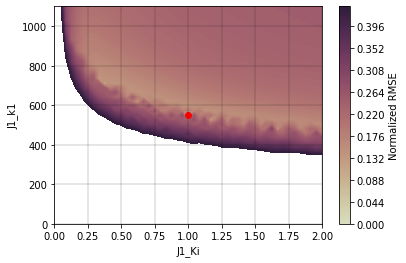

In [10]:
parameterDct = {"J1_Ki": 1, "J1_k1": 550}
analyzer = SurfaceAnalyzer(GMODEL, parameterDct)
for scale in [0.0004]:
    analyzer.runExperiments(1.0, 50)
    analyzer.plotSurface(scale=scale)

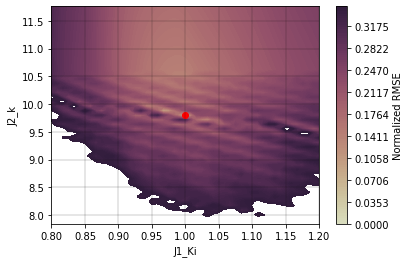

In [11]:
parameterDct = {"J1_Ki": 1, "J2_k": 9.8}
analyzer = SurfaceAnalyzer(GMODEL, parameterDct)
for scale in [0.03]:
    analyzer.runExperiments(0.2, 50)
    analyzer.plotSurface(scale=scale)

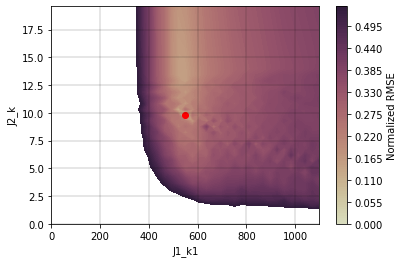

In [12]:
parameterDct = {"J1_k1": 550, "J2_k": 9.8}
analyzer = SurfaceAnalyzer(GMODEL, parameterDct)
for scale in [0.0005]:
    analyzer.runExperiments(1.0, 40)
    analyzer.plotSurface(scale=scale)

# FFL Analysis

In [21]:
X, Y, Z, k1, k2 = sympy.symbols("X Y Z k1 k2")

In [70]:
aMat = sympy.Matrix([ [0, 0, 0, 0], [1, -(1 + k2), 0, 0], [0, 1, -k1, 0], [0, k2, k1, 0]])
aMat

Matrix([
[0,       0,   0, 0],
[1, -k2 - 1,   0, 0],
[0,       1, -k1, 0],
[0,      k2,  k1, 0]])

In [71]:
aMat.eigenvals()

{0: 2, -k2 - 1: 1, -k1: 1}

In [69]:
expr = (-k1**2)**0.5
expr.subs(k1, 2)

2.0*I

In [51]:
expr = -(-k1**2 - k2**2 - 1)**0.5
expr = expr.subs(k1, 2)
expr.subs(k2, 3)

-3.74165738677394*I

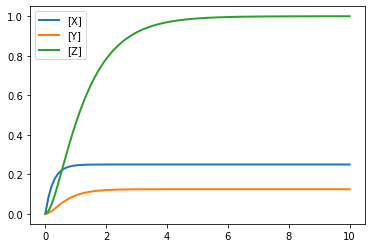

In [67]:
import tellurium as te
MODEL = """
$X0 -> X; 1
X -> Y; k0*X
Y -> Z; k1*Y
X -> Z; k2*X
Z -> $X1; Z

k0 = 1
k1 = 2
k2 = 3
"""
rr = te.loada(MODEL)
rr.plot(rr.simulate(0, 10, 100))

# Notes

1. Objectives
   1. Research - relate that nature of the fitting surface to the chemical network. Show in which cases the fitting surface is convex. Provide insights into strategies for fitting.
   1. Teaching - provide insights into what is happening with the different fitting algorithms by animating their steps.
   
1. Research directions
   1. Fitting surfaces by network type: linear, branched, feedback.
   1. Preliminary insights
      1. Detecting easily fit networks
      1. When do starting positions matter. For which parameters (because of combinatorics). How narrow parameter ranges (to reduce combinatorics).
      
1. A strategy for a linear chain (and maybe more general networks) is to first optimize the ratio of species concentrations.
But which ratios?

1. One strategy is to synthesize first order systems and solve them separately or recursively. Consider a linear system.
   1. Remove the constant term, since this is steady state.
   1. Integrate the rest.
   1. If the result is 0, stop.
   1. Otherwise, go to (a)
   
   Solve the last system found, since this is the high order system. Use these constants, and repeat.

1. To do
    1. Show simulations for different points in the curve, relating the simulation results to $R^2$.
    1. Look at longer linear chains.
    1. Examine Wolf model